Great — go ahead and upload the datasets now, and I’ll help you directly apply the KMeans clustering pipeline to them.
Please upload:

The small dataset (~4,000 rows)
The large dataset (~290,000 rows)
Once they're uploaded, I will:
Load and inspect the data structure.
Apply the 70/20/10 split.
Scale the features.
Perform PCA + t-SNE (2D & 3D).
Tune KMeans using elbow and silhouette.
Run final KMeans.
Analyze and label clusters.
Provide evaluation and explainability tools.
Please upload the files now.

In [78]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

import joblib


**Loading the Imputed Datasets**

In [79]:
# drop index columns
UK_data = pd.read_csv("/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/UK-cleaned_data.csv")
US_data = pd.read_csv("/Users/mahnooriqbal/COMP702 Project/ML-AI-Risk-Analysis-AV-Data-/Datasets/US_imputed_data.csv")
# Drop latitude and longitude columns
UK_data.drop(columns=['latitude', 'longitude','Report ID', 'Report Version'], inplace=True)
US_data.drop(columns=['Report ID', 'Report Version'], inplace=True)
# Print shape of each DataFrame
print("UK shape:", UK_data.shape)
print("US shape:", US_data.shape)
US_categorical_columns = [
    'Highest Injury Severity Alleged', 'Roadway Type', 'Lighting',
    'Weather', 'Roadway Surface', 'City', 'State','Country',
    'Weather', 'Roadway Surface', 'City', 'State','Country',
    'Make', 'Model', 'Model Year', 'ADS Equipped?', 'Automation System Engaged?',
    'Posted Speed Limit (MPH)', 'SV Pre-Crash Movement', 'SV Contact Area','Crash With'
]

datetime_cols = ['Incident Date', 'Incident Time (24:00)']
numerical_cols = []  # Add real numerical columns here if any
index_cols = []



UK shape: (229782, 19)
US shape: (4032, 19)


**Sample Large UK data**

In [80]:
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit

# Suppose the column you want to stratify on is named 'target_column'
target_col = 'Highest Injury Severity Alleged'  # replace this with your actual column name

# Stratified sampling: 20% sample size
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, sample_index in split.split(UK_data, UK_data[target_col]):
    UK_data = UK_data.iloc[sample_index]

print(UK_data[target_col].value_counts(normalize=True))  # check proportions


Highest Injury Severity Alleged
Minor       0.774507
Serious     0.210088
Fatality    0.015406
Name: proportion, dtype: float64


**Encode and Scale for K-Means++**

In [81]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm

def encode_data(df, categorical_cols, datetime_cols, numerical_cols, index_cols):
    """
    Encodes categorical columns using One-Hot Encoding with progress bar, 
    and processes datetime columns.
    """
    df_encoded = df.copy()
    encoders = {}

    # --- One-Hot Encoding for categorical columns ---
    if categorical_cols:
        for col in tqdm(categorical_cols, desc="Processing categorical columns"):
            if col in df_encoded.columns:
                df_encoded[col] = df_encoded[col].astype(str).fillna("Unknown")

        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # sklearn >= 1.2
        encoded_array = ohe.fit_transform(df_encoded[categorical_cols])
        encoded_df = pd.DataFrame(encoded_array, columns=ohe.get_feature_names_out(categorical_cols), index=df_encoded.index)

        # Drop original categorical columns and replace with one-hot encoded versions
        df_encoded.drop(columns=categorical_cols, inplace=True)
        df_encoded = pd.concat([df_encoded, encoded_df], axis=1)
        encoders['onehot'] = ohe

    # --- Convert datetime columns ---
    if 'Incident Date' in datetime_cols and 'Incident Date' in df_encoded.columns:
        df_encoded['Incident Date'] = pd.to_datetime(df_encoded['Incident Date'], errors='coerce')
        df_encoded['Incident_Year'] = df_encoded['Incident Date'].dt.year
        df_encoded['Incident_Month'] = df_encoded['Incident Date'].dt.month
        df_encoded['Incident_DayOfWeek'] = df_encoded['Incident Date'].dt.dayofweek
        df_encoded.drop(columns=['Incident Date'], inplace=True)

    if 'Incident Time (24:00)' in datetime_cols and 'Incident Time (24:00)' in df_encoded.columns:
        # Just extract hour instead of converting to seconds as taking too long
        try:
            df_encoded['Incident Time (24:00)'] = pd.to_datetime(
                df_encoded['Incident Time (24:00)'], 
                format='%H:%M:%S', 
                errors='coerce'
            ).dt.hour.fillna(0).astype(int)
        except Exception:
            pass


    return df_encoded, encoders

In [ ]:
US_encoded_df, US_encoders = encode_data(
    df=US_data,
    categorical_cols=categorical_columns,  # List of column names that are categorical
    datetime_cols=datetime_cols,            # List of date/time columns
    numerical_cols=numerical_cols,          # List of numeric columns
    index_cols=index_cols                    # List of index/ID columns
)
US_encoded_df = US_encoded_df.loc[:, (US_encoded_df != 0).any(axis=0)]

print("UK Data Shape:", US_encoded_df.shape)  # Should now have many more columns
print("\nUS Preview:")
print(US_encoded_df.head())


Processing categorical columns: 100%|██████████| 17/17 [00:00<00:00, 722.58it/s]

UK Data Shape: (4032, 1696)

US Preview:
   Incident Time (24:00)  Highest Injury Severity Alleged_Fatality  \
0                     14                                       0.0   
1                     22                                       0.0   
2                      7                                       0.0   
3                      6                                       0.0   
4                      3                                       0.0   

   Highest Injury Severity Alleged_Minor  \
0                                    1.0   
1                                    0.0   
2                                    1.0   
3                                    0.0   
4                                    1.0   

   Highest Injury Severity Alleged_Moderate  \
0                                       0.0   
1                                       0.0   
2                                       0.0   
3                                       0.0   
4                                     

In [85]:

UK_encoded_df, uk_encoders = encode_data(
    df=UK_data,
    categorical_cols=categorical_columns,  # List of column names that are categorical
    datetime_cols=datetime_cols,            # List of date/time columns
    numerical_cols=numerical_cols,          # List of numeric columns
    index_cols=index_cols                    # List of index/ID columns
)
UK_encoded_df = UK_encoded_df.loc[:, (UK_encoded_df != 0).any(axis=0)]
print("UK Data Shape:", UK_encoded_df.shape)  # Should now have many more columns
print("\nUK Preview:")
print(UK_encoded_df.head())

Processing categorical columns: 100%|██████████| 17/17 [00:00<00:00, 274.02it/s]


UK Data Shape: (45957, 4598)

UK Preview:
        Incident Time (24:00)  Highest Injury Severity Alleged_Fatality  \
40128                      14                                       0.0   
5542                        3                                       0.0   
37639                       7                                       0.0   
120167                     13                                       0.0   
58596                      16                                       0.0   

        Highest Injury Severity Alleged_Minor  \
40128                                     0.0   
5542                                      0.0   
37639                                     1.0   
120167                                    1.0   
58596                                     0.0   

        Highest Injury Severity Alleged_Serious  \
40128                                       1.0   
5542                                        1.0   
37639                                       0.0   
120167  

**K-Means++ Hyperparameter Testing using GridSearch**
- Best parameters for US Data: n_clusters=2, init=k-means++, max_iter=100, tol=0.0001 Best silhouette score: 0.6360

**Plotting Elbow Method**

In [84]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import ParameterSampler
import numpy as np
import matplotlib.pyplot as plt

def perform_kmeans_random_search(data, dataset_name, n_iter=30, random_state=42):
    print(f"\nPerforming K-Means randomized search for {dataset_name}...")

    param_distributions = {
        'n_clusters': range(2, 21),  # Try more cluster sizes
        'init': ['k-means++', 'random'],  # Add 'random'
        'max_iter': [300, 500, 1000],  # Try longer iterations
        'tol': [1e-4, 1e-3],  # Keep reasonable tolerance
        'n_init': [10, 20]  # Try more initializations
    }

    sampler = list(ParameterSampler(param_distributions, n_iter=n_iter, random_state=random_state))

    best_score = -1
    best_params = None
    scores = []

    for params in sampler:
        try:
            kmeans = KMeans(
                n_clusters=params['n_clusters'],
                init=params['init'],
                max_iter=params['max_iter'],
                tol=params['tol'],
                n_init=params['n_init'],
                random_state=random_state
            )
            labels = kmeans.fit_predict(data)
            score = silhouette_score(data, labels)
            scores.append((score, params))

            print(f"k={params['n_clusters']}, init={params['init']}, max_iter={params['max_iter']}, "
                  f"tol={params['tol']}, n_init={params['n_init']} => silhouette={score:.4f}")

            if score > best_score:
                best_score = score
                best_params = params

        except Exception as e:
            print(f"Failed for params {params}: {e}")

    print(f"\n🔍 Best parameters for {dataset_name}:")
    print(f"{best_params}")
    print(f"🏆 Best silhouette score: {best_score:.4f}")

    # Plot silhouette scores by n_clusters (filter by best init/tol/max_iter/n_init)
    filtered_scores = [
        s for s in scores if all([
            s[1]['init'] == best_params['init'],
            s[1]['tol'] == best_params['tol'],
            s[1]['max_iter'] == best_params['max_iter'],
            s[1]['n_init'] == best_params['n_init']
        ])
    ]
    ks = [s[1]['n_clusters'] for s in filtered_scores]
    sil_scores = [s[0] for s in filtered_scores]

    return best_params


# Example usage:
# us_best_params = perform_kmeans_random_search(US_encoded_df, "US Data", n_iter=5)
uk_best_params = perform_kmeans_random_search(UK_encoded_df, "UK Data", n_iter=5)


Performing K-Means randomized search for UK Data...


KeyboardInterrupt: 

US


KMeans Clustering Progress: 100%|██████████| 14/14 [00:09<00:00,  1.41it/s]


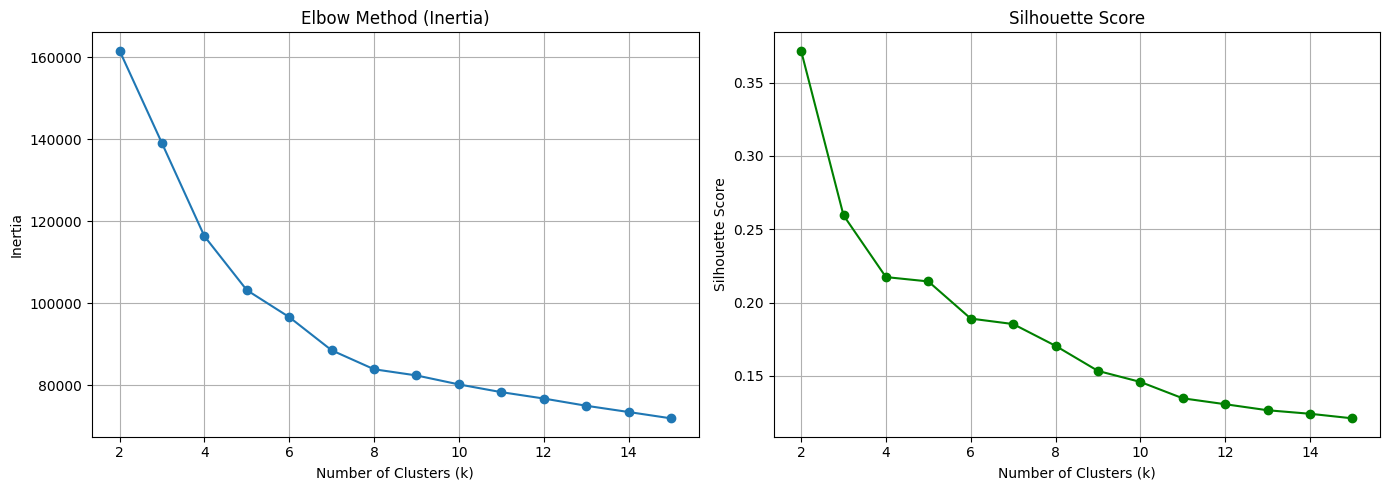

UK


KMeans Clustering Progress:   0%|          | 0/14 [02:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm

def plot_kmeans_elbow_silhouette(data, max_k=10):
    inertias = []
    silhouettes = []
    Ks = range(2, max_k + 1)

    for k in tqdm(Ks, desc="KMeans Clustering Progress"):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=1)  # n_init=1 for speed; you can use 'auto' for better stability
        labels = kmeans.fit_predict(data)
        inertias.append(kmeans.inertia_)

        # Calculate silhouette score for the entire dataset
        score = silhouette_score(data, labels, random_state=42)
        silhouettes.append(score)

    fig, ax = plt.subplots(1, 2, figsize=(14, 5))

    ax[0].plot(Ks, inertias, marker='o')
    ax[0].set_title('Elbow Method (Inertia)')
    ax[0].set_xlabel('Number of Clusters (k)')
    ax[0].set_ylabel('Inertia')
    ax[0].grid(True)

    ax[1].plot(Ks, silhouettes, marker='o', color='green')
    ax[1].set_title('Silhouette Score')
    ax[1].set_xlabel('Number of Clusters (k)')
    ax[1].set_ylabel('Silhouette Score')
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

print("US")
#plot_kmeans_elbow_silhouette(US_encoded_df, max_k=15)

print("UK")
plot_kmeans_elbow_silhouette(UK_encoded_df, max_k=15)



US - DBSCAN


DBSCAN Clustering Progress: 100%|██████████| 20/20 [00:05<00:00,  3.48it/s]


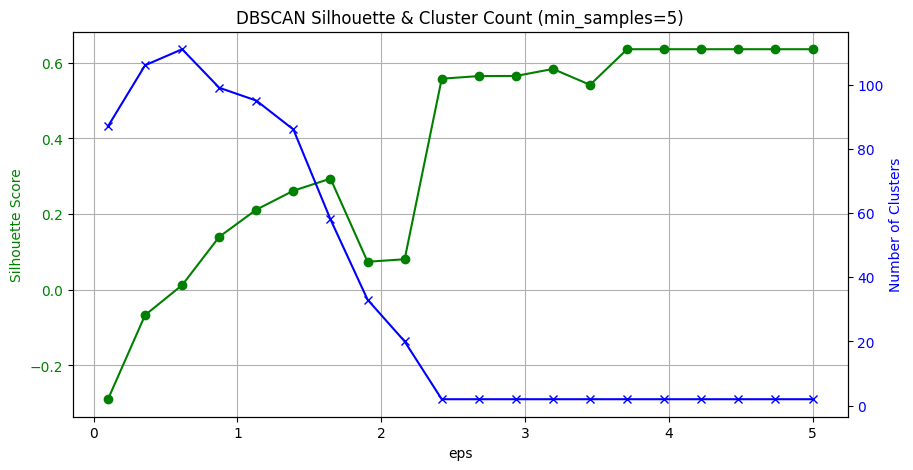

UK - DBSCAN


DBSCAN Clustering Progress: 100%|██████████| 20/20 [03:55<00:00, 11.75s/it]


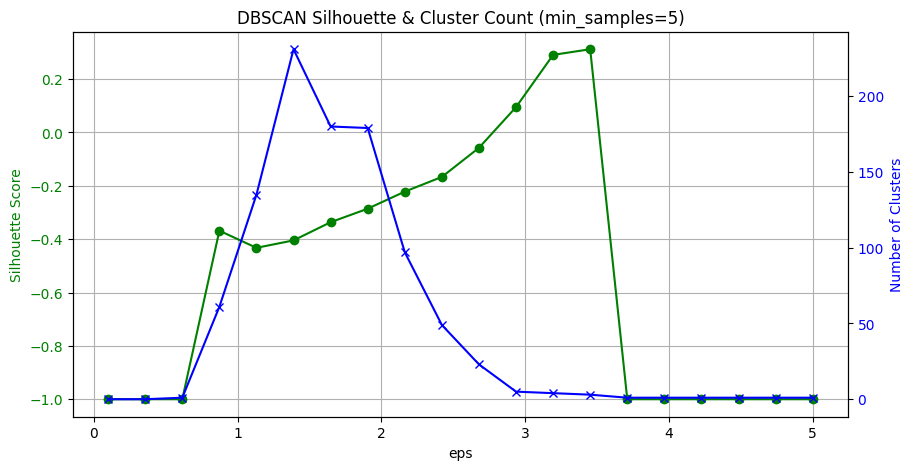

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def plot_dbscan_silhouette(data, eps_values, min_samples=5):
    silhouettes = []
    num_clusters = []

    for eps in tqdm(eps_values, desc="DBSCAN Clustering Progress"):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(data)
        
        # Count clusters (excluding noise label -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        num_clusters.append(n_clusters)

        # Compute silhouette score only if there are at least 2 clusters
        if n_clusters > 1:
            score = silhouette_score(data, labels)
        else:
            score = -1  # Invalid silhouette for single/no cluster
        silhouettes.append(score)

    fig, ax1 = plt.subplots(figsize=(10, 5))
    ax1.plot(eps_values, silhouettes, marker='o', label='Silhouette Score', color='green')
    ax1.set_xlabel('eps')
    ax1.set_ylabel('Silhouette Score', color='green')
    ax1.tick_params(axis='y', labelcolor='green')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(eps_values, num_clusters, marker='x', label='Number of Clusters', color='blue')
    ax2.set_ylabel('Number of Clusters', color='blue')
    ax2.tick_params(axis='y', labelcolor='blue')

    plt.title(f'DBSCAN Silhouette & Cluster Count (min_samples={min_samples})')
    plt.show()

# Example usage
eps_range = np.linspace(0.1, 5, 20)  # Adjust range depending on your data scale

print("US - DBSCAN")
# plot_dbscan_silhouette(US_scaled, eps_range, min_samples=5)

print("UK - DBSCAN")
plot_dbscan_silhouette(UK_scaled, eps_range, min_samples=5)
